In [37]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
#!pip install opencv-contrib-python
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
from PIL import Image
from PIL import ImageFilter
import cv2
import numpy as np
import anvil.server
import anvil.server
!pip install moviepy
import moviepy.editor as mp

In [38]:
# !pip install azure-cognitiveservices-speech
# !pip install google-api-python-client 
# !pip install --upgrade google-cloud-speech
#!pip install anvil-uplink
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google-cloud-speech

In [39]:
import anvil.server
anvil.server.connect("server_PFOYW7TJUDIUZD4RDEWND7YY-ORZU3UXU6JCOS2XW")
import anvil.media
from shutil import copy

In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
# !pip install keras
# !pip install tensorflow
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [41]:
data = pd.read_csv('icml_face_data.csv')
#48 x 48

In [42]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [43]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions(train_images,emotions,train_labels):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(emotions, test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(emotions, array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [73]:
def driverFunction(data):
    data[' Usage'].value_counts()
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
    val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
    test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])
    train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
    train_images = train_images.astype('float32')/255
    val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
    val_images = val_images.astype('float32')/255
    test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
    test_images = test_images.astype('float32')/255
    train_labels = to_categorical(train_image_label)
    val_labels = to_categorical(val_image_label)
    test_labels = to_categorical(test_image_label)
    plot_all_emotions(train_images,emotions,train_labels)
    plot_compare_distributions(emotions,train_labels, val_labels, title1='train labels', title2='val labels')
    class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('test caccuracy:', test_acc)
    pred_test_labels = model.predict(test_images)
    plot_image_and_emotion(emotions,test_image_array, test_image_label, pred_test_labels, 104)
    #return test_acc
    return model

In [45]:
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255
# pred_test_labels = model.predict(test_images[:1])
# print(pred_test_labels)

In [46]:
#plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 104)

In [47]:
def Grayscale(name1):
    img = Image.open(name1)
    imgGray = img.convert('L')
    return np.array(imgGray)

In [48]:
def Binary_Thresholding(name1,val,maxi):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(img,val,maxi, cv2.THRESH_BINARY)
    return np.array(thresh1)

In [49]:
def Truncated_Thresholding(name1,val,maxi):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh2 = cv2.threshold(img,val,maxi,cv2.THRESH_TRUNC)
    return np.array(thresh1)

In [50]:
def Thresholding_To_Zero(name1,val = 120,maxi = 255):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh3 = cv2.threshold(img,val,maxi,cv2.THRESH_TOZERO)
    return np.array(thresh3)

In [51]:
def invert(name1):
    image1 = cv2.imread(name1,0)
    image1 = cv2.bitwise_not(image1)
    return np.array(image1)

In [52]:
def sharpen(name1):
    img = Image.open(name1)
    sharpened1 = img.filter(ImageFilter.SHARPEN);
    sharpened2 = sharpened1.filter(ImageFilter.SHARPEN);
    sharpened3 = sharpened2.filter(ImageFilter.SHARPEN);
    return np.array(sharpened3)

In [53]:
def reduce(array):
    reduced=[]
    for j in array:
        row=[]
        for i in j:
            row.append(i[0])
        reduced.append(row)
    return np.array(reduced)

In [54]:
def blur(name1):
    img = cv2.imread(name1)
    img = cv2.blur(img, (3,3)) 
    return reduce(np.array(img))

In [55]:
def min(name1):
    img=Image.open(name1)
    img2=img.filter(ImageFilter.MinFilter(size=3))
    return np.array(img2)

In [56]:
def max(name1):
    img=Image.open(name1)
    img2=img.filter(ImageFilter.MaxFilter(size=3))
    return np.array(img2)

In [57]:
d={0:"Grey-scaling",1:"Thresholding",2:"Inversion",3:"Blurring",4:"Sharpening",5:"Min",6:"Max"}

def GenerateCombinations(imageName, N): #give input as file name and mask, returns the new image pixel values
     #number of different operations we have [greyscaling, thresholding etc
    if(N==0):
        return reduce(cv2.imread(imageName))
    operationsList=[]
    for j in range(0,32):
        if(N&(1<<j)):
            operationsList.append(d[j])
    newArray=[]
    print(operationsList)
    for operations in operationsList:
        enter=0
        if(operations=="Grey-scaling"):
            enter=1
            newArray=Grayscale(imageName)
        elif(operations=="Thresholding"):
            enter=1
            newArray=Binary_Thresholding(imageName, 100, 200)
        elif(operations=="Inversion"):
            enter=1
            newArray=invert(imageName)
        elif(operations == "Blurring"):
            enter=1
            newArray=blur(imageName)
        elif(operations == "Sharpening"):
            enter=1
            newArray=sharpen(imageName)
        elif(operations == "Min"):
            enter=1
            newArray=min(imageName)
        elif(operations == "Max"):
            enter=1
            newArray=max(imageName)
        if(enter):
            new_image = Image.fromarray(newArray)
            new_image.save(imageName)
    return newArray

GenerateCombinations("anvil10_3.png",32)

['Min']


array([[200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       [200, 200, 200, ..., 200, 200, 200],
       ...,
       [200, 200, 200, ..., 178, 178, 178],
       [200, 200, 200, ..., 178, 178, 178],
       [200, 200, 200, ..., 178, 178, 178]], dtype=uint8)

In [58]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [59]:
# for mask in range(1,(1<<4)):
#     data = pd.read_csv('icml_face_data.csv')
#     for index in range(10):
#         row=[]
#         pix=[]
#         for i in range(len(data[' pixels'].iloc[index].split(" "))):
#             row.append(int(data[' pixels'].iloc[index].split(" ")[i]))
#             if(len(row)==48):
#                 pix.append(row)
#                 row=[]
#         array = np.array(pix, dtype=np.uint8)
#         newdata=""
#         new_image = Image.fromarray(array)
#         new_image.save('dummy.png')
#         new_array=GenerateCombinations("dummy.png",mask)
#         for i in new_array:
#             for j in i:
#                 newdata+=str(j)
#                 newdata+=" "
#         newdata=newdata[:-1]
#         data[' pixels'].iloc[index]=newdata
#     print(data.head())
#     print(data.shape[0])
#     driverFunction(data)
#     break

In [60]:
mask=0 #global mask

In [61]:
def check(image,prev):
    count=0
    for i in range(len(image)):
        for j in range(len(image[i])):
            for k in range(len(image[i][j])):
                if(image[i][j][k]!=prev[i][j][k]):
                    count+=1
    if(count>230): #more than 10% change
        return True
    return False

In [62]:
import cv2
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
freq = {'Angry': 0, 'Disgust': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprise': 0, 'Neutral': 0}
def getFrames(file):
    global emotions
    global freq
    dataSet="Mask"+str(mask)+".csv"
    data = pd.read_csv(dataSet)
    print("calling driver")
    model=driverFunction(data)
    print("driver done")
    vidcap=cv2.VideoCapture(file) #capture and read the video file
    success,image=vidcap.read()
    prev=image
    while success:
        image=cv2.resize(image, (48,48), interpolation = cv2.INTER_AREA)
        if(check(image,prev)):
            cv2.imwrite("frame.png",image)
            image = cv2.imread("frame.png")
            #Show the image with matplotlib
            #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            #plt.show()
            newdata=""
            new_array=GenerateCombinations("frame.png",mask) #place mask on the input image as well
            plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
            plt.show()
            for i in new_array:
                for j in i:
                    newdata+=str(j)
                    newdata+=" "
            newdata=newdata[:-1]
            row=[]
            pix=[]
            newdata=newdata.split(" ")
            for i in range(len(newdata)):
                row.append([int(newdata[i])])
                if(len(row)==48):
                    pix.append(row)
                    row=[]
            array = np.array(pix, dtype=np.uint8)
            test_images[0]=array #just change the first row of test_images 
            pred_test_labels = model.predict(test_images[:1])[0] #predict
            mx=__builtin__.max(pred_test_labels)
            for i in range(len(pred_test_labels)):
                if(pred_test_labels[i]==mx):
                    freq[emotions[i]]+=1
        prev=image
        success,image=vidcap.read()
    return freq
#print(getFrames("tr.mp4"))

In [63]:
def getAudio(file):
    my_clip = mp.VideoFileClip(file)
    my_clip.audio.write_audiofile(r"finally.mp3")
    return 1

In [64]:
def runApplication(fileName):
    outputVideo=getFrames(fileName)
    outputAudio=getAudio(fileName) #audio is written in finally.mp3 and sent to meetingOWL project [done]
    return [outputVideo,outputAudio]

In [65]:
@anvil.server.callable
def write_media_to_file(media_object):
    with anvil.media.TempFile(media_object) as f:
        #file stored in finally.mp3
        copy(f, "finally.mp4")
        #convert the speech to text
        result=runApplication("finally.mp4")
        #return {'Angry': 3, 'Disgust': 4, 'Fear': 5, 'Happy': 8, 'Sad': 1, 'Surprise': 3, 'Neutral': 0}
        return result[0]

In [66]:
@anvil.server.callable
def analyze():
    result=runApplication("finally.mp4")
    #return {'Angry': 3, 'Disgust': 4, 'Fear': 5, 'Happy': 8, 'Sad': 1, 'Surprise': 3, 'Neutral': 0}
    return result[0]

In [67]:
@anvil.server.callable
def updateMask(bitNumber,status):
    global mask
    if(status==True):
        mask|=(1<<bitNumber)
    else:
        mask&=~(1<<bitNumber)
    print(mask)
    return mask

In [68]:
# data = pd.read_csv('icml_face_data.csv')
# for index in range(5):
#     row=[]
#     pix=[]
#     for i in range(len(data[' pixels'].iloc[index].split(" "))):
#         row.append(int(data[' pixels'].iloc[index].split(" ")[i]))
#         if(len(row)==48):
#             pix.append(row)
#             row=[]
#     array = np.array(pix, dtype=np.uint8)
#     newdata=""
#     new_image = Image.fromarray(array)
#     new_image.save('dummy'+str(index)+'.png')

In [69]:
# for msk in range(1,15):
#     try:
#         data = pd.read_csv('Mask'+str(msk)+'.csv')
#     except:
#         continue
#     listz=[]
#     for maskB in range(0,7):
#         print("lolz")
#         for j in range(data.shape[0]):
#             if(data['emotion'].iloc[j]==maskB):
#                 row=[]
#                 pix=[]
#                 for i in range(len(data[' pixels'].iloc[j].split(" "))):
#                     row.append(int(data[' pixels'].iloc[j].split(" ")[i]))
#                     if(len(row)==48):
#                         pix.append(row)
#                         row=[]

#                 array = np.array(pix, dtype=np.uint8)
#                 new_image = Image.fromarray(array)
#     #             print(new_image)
#     #             print(len(array),len(array[0]))
#     #             print('anvil'+str(maskB)+'.png')
#                 new_image.save('anvil'+str(maskB)+'.png')
#                 image = cv2.imread('anvil'+str(maskB)+'.png')
#                 #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#                 #plt.show()
#                 new_array=Image.fromarray(GenerateCombinations('anvil'+str(maskB)+'.png',10))
#                 listz.append(new_array)
#                 new_array.save('anvil10_'+str(maskB)+'.png')
#                 break
#     rows=3
#     cols =3
#     img_count = 0

#     fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
#     maskB=0
#     co=0
#     keyz=list({'Angry': 3, 'Disgust': 4, 'Fear': 5, 'Happy': 8, 'Sad': 1, 'Surprise': 3, 'Neutral': 0}.keys())
#     for i in range(rows):
#         for j in range(cols):        
#             if True:
#                 f=0
#                 if(maskB==6):
#                     maskB+=1
#                     continue
#                 if(maskB>=7):
#                     f=1
#                     maskB-=1

#                 image = cv2.imread('anvil'+str(maskB)+'.png')

#                 axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#                 axes[i,j].set_title(keyz[img_count],fontstyle='italic')

#                 maskB+=1
#                 img_count+=1
#                 if(f):
#                     break
                    
#     fig.delaxes(axes[2][0])
#     fig.delaxes(axes[2][-1])
#     fig.savefig('final'+str(msk)+'.png')
# # for label, ax in axes[0][0]:
# #     ax.set_title('Normal Title', fontstyle='italic')
# #     ax.set_title(label, fontfamily='serif', loc='left', fontsize='medium')


In [70]:
#!pip install tabulate


In [71]:
# # import module
# from tabulate import tabulate
# # assign data
# mydata = []
# for MASKiter in range(18):
#     data = pd.read_csv('Mask'+str(MASKiter)+'.csv')
#     acc=driverFunction(data)
#     mydata.append(["Mask"+str(MASKiter),str(acc)])

# # create header
# head = ["Binary mask", "Accuracy"]



calling driver


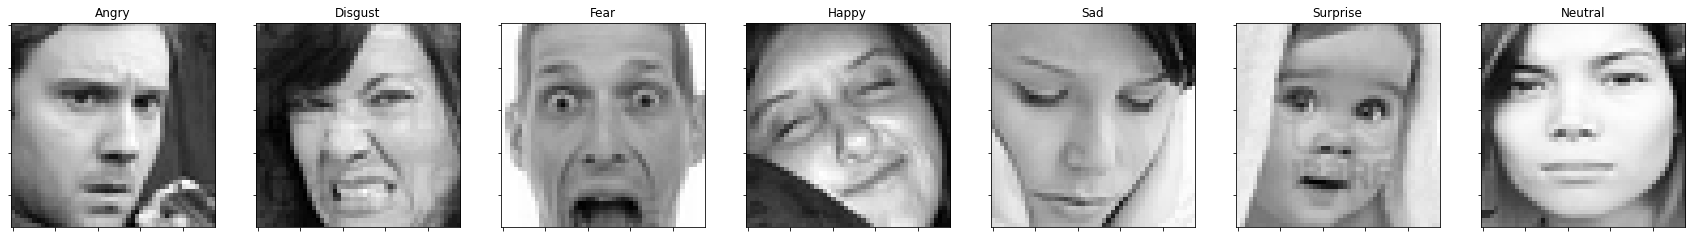

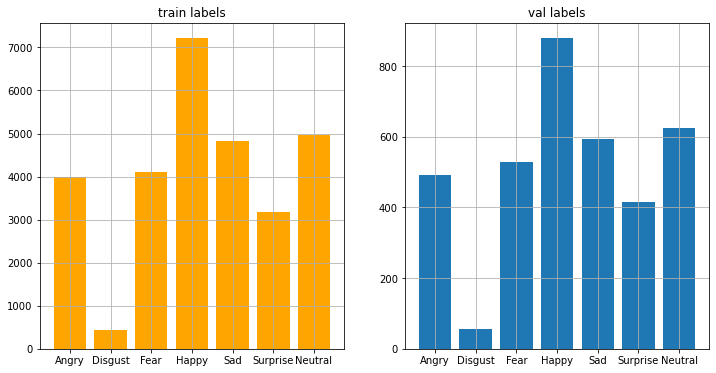

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

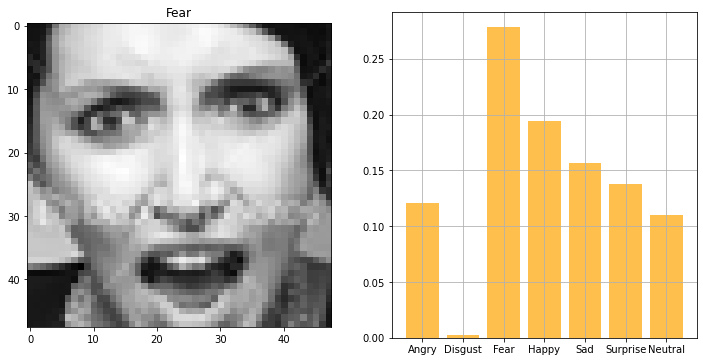

driver done


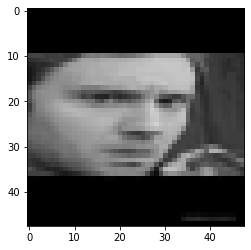

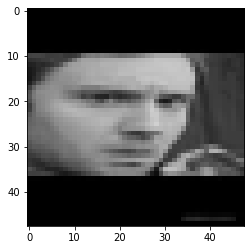

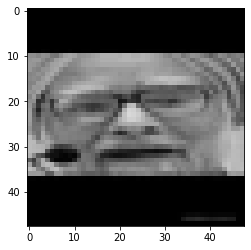

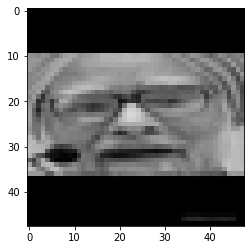

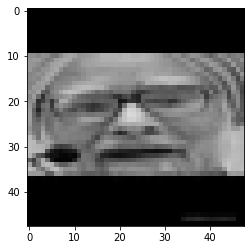

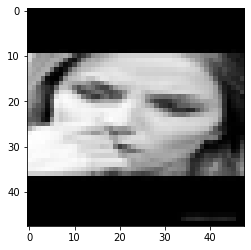

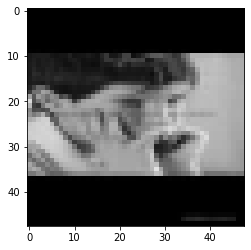

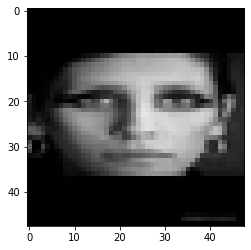

chunk:   1%|▊                                                                | 3/231 [00:00<00:10, 21.05it/s, now=None]

MoviePy - Writing audio in finally.mp3


MoviePy - Done.
2
10
14
calling driver


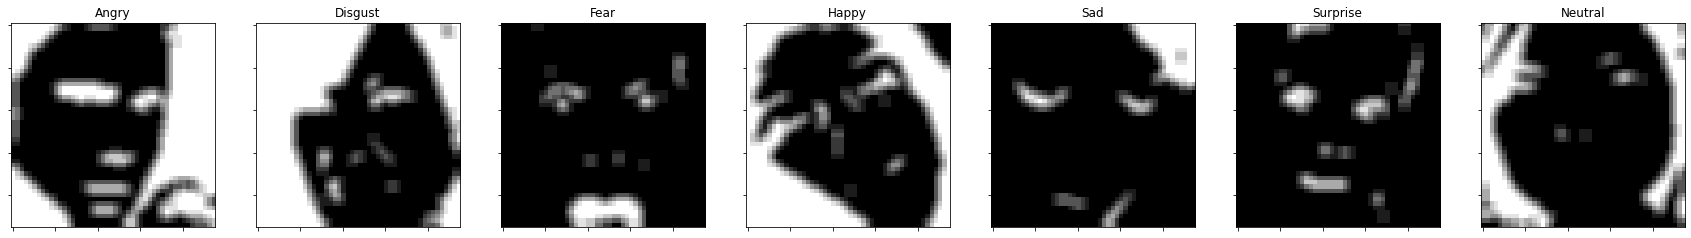

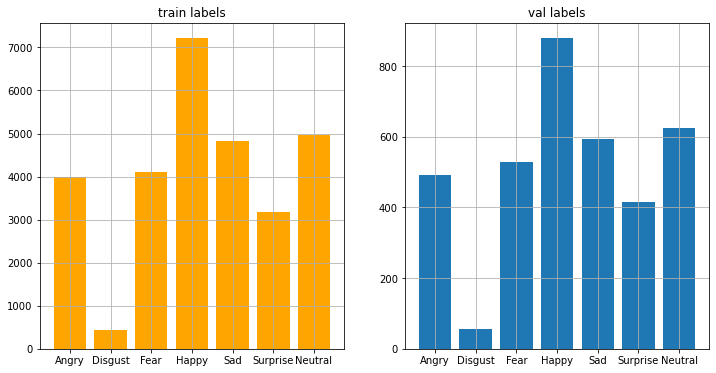

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

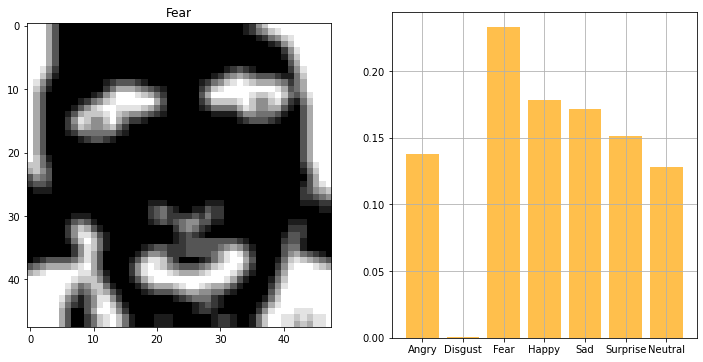

driver done
['Thresholding', 'Inversion', 'Blurring']


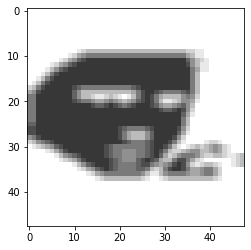

['Thresholding', 'Inversion', 'Blurring']


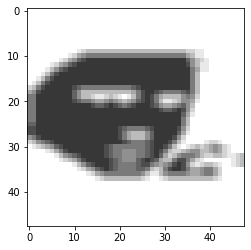

['Thresholding', 'Inversion', 'Blurring']


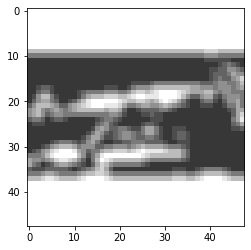

['Thresholding', 'Inversion', 'Blurring']


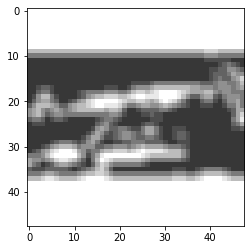

['Thresholding', 'Inversion', 'Blurring']


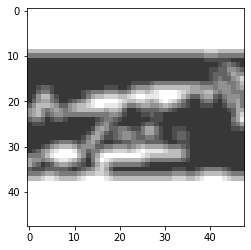

['Thresholding', 'Inversion', 'Blurring']


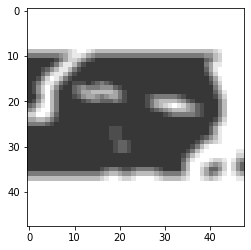

['Thresholding', 'Inversion', 'Blurring']


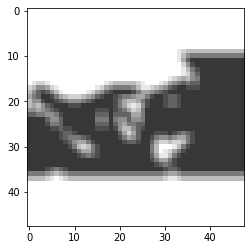

['Thresholding', 'Inversion', 'Blurring']


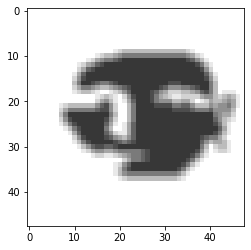

chunk:   1%|▊                                                                | 3/231 [00:00<00:08, 25.38it/s, now=None]

MoviePy - Writing audio in finally.mp3


MoviePy - Done.


In [72]:
# display table
#print(tabulate(mydata, headers=head, tablefmt="grid"))